# INF8775 – Analyse et conception d’algorithmes
# TP2 – Hiver 2024

Nguyen, Huy Viet, 2136374

Some, Freddy, 1930443

Note finale :

 <u>**Date limite de remise :**</u>  27 mars 23h59 (Groupe B1), 19 mars 23h59 (Groupe B2)

# Instructions

## Rédaction et remise du rapport

- Ce notebook constitue à la fois le sujet du TP, votre code et votre rapport. Il contient déjà du code pour faciliter vos mesures et l'affichage de vos résultats, ainsi qu'un squelette pour votre rapport.

- Complétez directement le notebook, vous êtes libres de créer de nouvelles cellules de code ou de texte. 

- Remettez le fichier du notebook sur Moodle avec le nom `NOM1_MATRICULE1_NOM2_MATRICULE2.ipynb`

- Vous pouvez inclure du code trouvé sur Internet, mais vous devez en mentionner la source, sous peine d'être sanctionnés pour plagiat.

## Mise en situation

Ce travail pratique se répartit sur deux séances de laboratoire et porte sur l'analyse et la conception d'algorithmes développés suivant différents patrons de conception afin de résoudre une version simplifiée d'un problème réaliste d'optimisation.


## Description du problème

Un pianiste souhaite jouer une mélodie donnée par une partition. La mélodie est une suite de n notes *(a0, a1, ... , an-1)* où chaque ai appartient à un ensemble de m notes numérotées de 0 à m-1.

Le pianiste peut choisir de jouer chaque note avec l’un de ses D doigts. Le passage de la note i1 jouée avec le doigt d1 à la note i2 jouée avec le doigt d2 est pénalisée par une fonction de difficulté de la transition *C(i1, d1, i2, d2)*. Notre pianiste souhaite donc déterminer avec quel doigt il doit jouer chaque note de la mélodie de façon à minimiser la somme des coûts de chaque transition.

Pour la partie empirique de ce TP, nous nous limiterons à des mélodies jouées à une main (D=5) sur deux octaves (m=24).

Soit l’exemple suivant avec 5 notes :

- L'exemplaire est : `[17, 21, 18, 2, 21, 15, 11, 16]`
- La solution est : `[2, 1, 1, 0, 1, 1, 2, 1]`

La figure ci-dessous représente la partition avec ça solution et le coût associé à chaque transition (en gris).

![alt text](example_solution.png "Title")

## Algorithmes à implanter

Trois algorithmes seront implantés, mettant en pratique des patrons de conception différents :

1. Un algorithme glouton
2. Un algorithme de programmation dynamique
3. Un algorithme de recherche locale


## Jeu de données

La fonction `generate_sample` ci-dessous permet de générer un exemplaire d'une taille donnée.

La fonction `get_dataset` permet de récupérer un dataset pour la liste de taille fournie. Elle prend également en entrée un graine aléatoire pour générer le dataset en question.

Afin que chaque groupe travaille avec un set différent, mais que vos propres expériences soient reproductibles, entrez l'un de vous matricule comme graine aléatoire dans la cellule ci-dessous.

Vous êtes bien entendu libres de tester et mesurer vos algorithme sur le même dataset qu'un autre groupe. Pour cela, générez simplement un dataset avec la même graine et la même liste de taille.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.stats import linregress
import time

In [2]:
def visualize_solution(costs, partition, solution):
    """
    Visualisez votre solution et les coûts associés.    
    """
    # Create a figure and axis
    _, ax = plt.subplots()
    
    # Plot the notes as circles with their sizes proportional to the partition values
    for i in range(len(partition)):
        ax.scatter([i], [partition[i]], marker='o')
        ax.text(i, partition[i] + 0.2, str(solution[i]), ha='center', va='bottom')
    
    # Set the limits for the axes to fit the plot
    ax.set_ylim(min(partition) - 1, max(partition) + 1)
    ax.set_xlim(-0.5, len(partition)-0.5)
    
    # Label the axes
    ax.set_xlabel('Partition')
    ax.set_ylabel('Note')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Title the plot
    ax.set_title('Partition et doigts utilisés')

    plot_costs = getCosts(costs, partition, solution).tolist()
    plot_costs.append(0)

    ax2 = ax.twinx()
    ax2.bar(range(len(partition)), plot_costs, width=1, alpha=0.5, align='edge', color='gray')
    ax2.set_xlim(-0.5, len(partition)-0.5)
    ax2.set_ylim(0, 100)
    
    # Remove the ticks and tick labels from the secondary y-axis
    ax2.tick_params(axis='both', which='both', length=0)
    ax2.set_yticklabels([])
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)    
    # Show the plot
    plt.show()

def generate_sample(size, maxValue=24):
    return np.random.randint(0, maxValue, size).tolist()

def get_dataset(seed, sizes):
    np.random.seed(seed)
    return { size: [generate_sample(size) for _ in range(5)]
        for size in sizes }

def readFile(filePath):
    """
    Charger une partition depuis un fichier
    """
    f = open(filePath)
    N = int(f.readline())
    partition = list(map(int, f.readline().split(' ')))
    f.close()
    return partition

def getCosts(costs, partition, solution):
    """
    Liste des coûts associés à chaque transition de votre solution.
    """
    prevNotes, nextNotes = partition[:-1], partition[1:]
    prevFingers, nextFingers = solution[:-1], solution[1:]
    return costs[prevNotes, prevFingers, nextNotes, nextFingers]

def getTotalCost(costs, partition, solution):
    """
    Coût total de votre solution
    """
    return np.sum(getCosts(costs, partition, solution))

Exécutez la cellule suivante afin d'obtenir le tenseur des coûts associé à chaque transition.

In [3]:
load_file = np.loadtxt('cout_transition.txt', dtype=int)
costs = load_file.reshape((24, 5, 24, 5))
D = 5    # Nombre de doigts
M = 24   # Etendue des notes (2 octaves)

partition = readFile('Chansons/twinkle_twinkle.txt')

# Implantations et expérimentations

Ces fonctions auxiliaires vous sont fournies pour vérifier l'exactitude des vos algorithmes, mesurer leurs performance et afficher vos résultats.

Il est recommandé de prendre le temps de lire et comprendre le code.

Exécutez la cellule ci-dessous pour pouvoir utiliser les fonctions auxiliaires.

In [4]:
def measure(procedure, sample):
    """ Mesure le temps d'execution d'une procédure sur un unique exemplaire """
    start = time.time()
    solution = procedure(sample)
    end = time.time()
    sorting_time = end - start
    return solution, sorting_time


def measure_mean_time(procedure, samples):
    total_time = 0
    for i in range(len(samples)):
        sample = samples[i]
        _, compute_time = measure(procedure, sample)
        total_time += compute_time
        print(f"Computing {procedure.__name__} on sample {i+1} of size {len(sample)}...          ", end='\r')
    return total_time / len(samples)


def measure_procedure(procedure, dataset):
    """ Mesure les temps moyens d'execution d'une procédure sur chaque point d'un dataset """
    return {size: measure_mean_time(procedure, samples) for size, samples in dataset.items()}

def display_measures_table(measures):
    print("{: <12} {: <12}".format("Taille", "Temps moyen (s)"))
    for size, measure in measures.items():
        print("{: <12} {: <12}".format(size, measure))


def display_test_puissance(vals, title="Test de puissance"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)
    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2f}x + {b:.2f}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label=f'Regression linéaire R²={round(rvalue**2,4)}')

    # Add labels and title
    plt.xlabel('log Taille')
    plt.ylabel('log Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

def display_test_rapport(vals, title="Test du rapport"):
    x = list(vals.keys())
    y = list(vals.values())

    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel('Taille')
    plt.ylabel('Temps / f(taille)')
    plt.title(title)
    plt.show()


def display_test_constantes(vals, title="Test des constantes"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)

    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2E}x + {b:.2E}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label=f'Regression linéaire R²={round(rvalue**2,4)}')

    # Add labels and title
    plt.xlabel('f(Taille)')
    plt.ylabel('Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

## Partie 1 : Algorithme glouton

Implantez un algorithme suivant le patron de conception glouton.

L'algorithme glouton fait son choix en fonction du coût de la prochaine transition :

Les deux premiers doigts d0 et d1 sont choisis de façon à minimiser C(a0, d0, a1, d1). Puis, étant donné le
doigt précédent d et la transition de la note i vers la note j, le choix glouton porte sur le doigt d’ qui
minimise C(i, d, j, d’).

Tentez de rendre votre implantation la plus performante possible en évitant des calculs inutiles.

Coût Glouton : 55


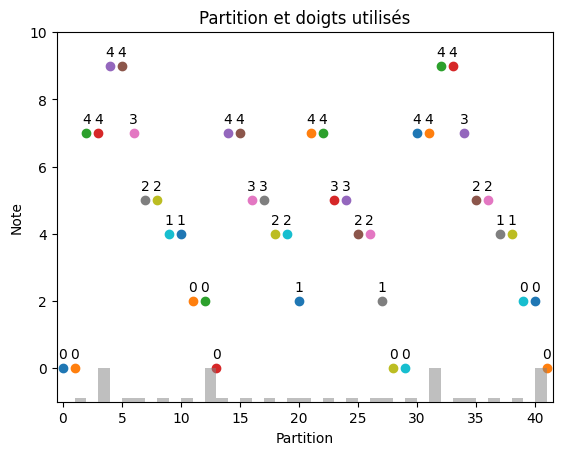

In [5]:
import itertools


# Trouve un doigt optimal pour une transition
def get_next_finger(previous_finger, transition, number_of_fingers):
    next_finger = -1
    cout = 101
  
    for i in reversed(range(number_of_fingers)):  # L'itération reversed donne de meilleurs résultats
        cout_courant = getCosts(costs, transition, [previous_finger, i])
        if cout_courant == 0:
            next_finger = i
            break
            
        elif cout > cout_courant:
            cout = cout_courant
            next_finger = i
    
    return next_finger


def glouton(partition):
    solution = []
    
    cout = 101
    minimum = (-1, -1)

    for i, j in itertools.product(range(D), range(D)):
        cout_courant = getCosts(costs, partition[:2], [i, j])
        if cout_courant == 0:
            minimum = (i, j)
            break
        
        elif cout > cout_courant:
            cout = cout_courant
            minimum = (i, j)
              
    solution.append(minimum[0])
    solution.append(minimum[1])
    
    next_finger = -1
    for i in range(2, len(partition)):
        next_finger = get_next_finger(next_finger, [partition[i-1], partition[i]], D)
        solution.append(next_finger)

    return solution


solutionGlouton = glouton(partition)
print("Coût Glouton :", getTotalCost(costs, partition, solutionGlouton))
visualize_solution(costs, partition, solutionGlouton)

Nous avons trouvé que d'itérer des valeurs les plus grandes au plus petites valeurs des doigts dans la fonction get_next_finger donne de meilleurs résultats. Ceci s'explique probablement par le fait que les transitions vers des doigts croissants sont en général plus coûteux que des transitions vers des doigts décroissants, ce qui implique qu'il est plus avantageux de choisir des transitions (i, j) où i >= j.

### Analyse asymptotique

Dans cette analyse, vous tiendrez compte à la fois de la longueur de la mélodie mais également du
nombre de doigts pour chacun des trois algorithmes.

L'analyse de l'algorithme est fait pour un nombre $d$ de doigts et un nombre $k$ pour la longueur de la mélodie.

L'algorithme glouton effectue en premier la recherche de la première transition la plus optimale. Cette recherche s'arrête lorsque toutes les transitions possibles ont été évaluées ou lorsqu'une transition dont le coût est nul est trouvée. Il est donc possible que la recherche va itérer, dans le meilleur cas, sur une seule transition ou, dans le pire cas, toutes les transitions possibles ($d^2$ au total). Par conséquent, on peut déduire que la complexité de la recherche de la première transition optimale est en $\Omega(1)$ et en $O(d^2)$.

Ensuite, on itère sur le reste de la mélodie pour trouver le doigt à jouer pour les prochaines notes en appelant la fonction get_next_finger à chaque itération. La fonction get_next_finger fait une boucle sur tous les doigts pour trouver lequel d'entre eux permet d'avoir la transition avec le plus petit coût, la boucle s'arrête lorsqu'on trouve une transition avec un coût nul ou lorsqu'on a finit d'itérer sur les $d$ doigts possibles. Puisque la fonction getCosts, qui est appelé à chaque itération de la boucle, est en $\Theta(1)$ parce qu'on l'appelle toujours avec la même taille d'exemplaire, on peut déduire que chaque itération de la boucle est en $\Theta(1)$. Alors, on déduit que la complexité de la boucle est en $\Omega(1)$ et en $O(d)$. Donc, la complexité de la fonction est get_next_finger en $\Omega(1)$ et en $O(d)$. La recherche des prochaines notes après la première transition se fait donc en $k \times \Omega(1) = \Omega(k)$ et en $k \times O(d) = O(kd).$

En conclusion, la complexité en temps de calcul de l'algorithme est en $\Omega(1) + \Omega(k) = \Omega(k)$ et en $O(d^2) + O(kd) = O(d^2 + kd)$. On remarque que le temps de calcul croit linéairement en fonction de $k$ et croit de manière quadratique en fonction de $d$. Ceci permet de déduire que, lorsque la valeur de $d$ est fixée, la complexité de l'algorithme est en $\Theta(k)$, et que, lorsque la valeur de $k$ est fixée, la complexité de l'algorithme est en $\Omega(1)$ et en $O(d^2)$.

Puisque l'algorithme glouton crée une liste de taille k pour stocker la solution, on peut aussi déduire que la complexité en terme de mémoire est $\Theta(k)$.

La validation empyrique ci-dessous et les suivantes seront faites uniquement pour des longueurs de mélodies qui varient et un nombre de doigts constant $d=5$, ce qui permettrait de confirmer la complexité de l'algorithme dans le cas d'un nombre de doigts qui est fixé. La raison est qu'il n'est pas particulièrement pertinent de faire la validation pour une taille de mélodie constante et un nombre de doigts variable alors qu'on n'a pas les coûts pour les cas où on a plus de cinq doigts. En effet, la complexité de l'algorithme représente sa consommation en ressources pour des tailles d'exemplaire suffisamment grands, ce qui est impossible à vérifier lorsqu'on peut uniquement faire l'exécution de l'algorithme glouton pour des nombres de doigts entre 1 et 5 (supposant que le tableau des coûts reste valide si on fixe $d$ à une valeur entre 1 et 4).

### Mesures

Rapportez dans un tableau les temps d'exécutions moyens avec les fonctions auxiliaires `measure_procedure` et `display_measure_table`

In [6]:
dataset = get_dataset(2136374, [1600, 3200, 6400, 12800, 25600, 51200, 80000, 102400, 150000, 204800, 300400])

In [7]:
mesures_glouton = measure_procedure(glouton, dataset)

In [8]:
display_measures_table(mesures_glouton)

Taille       Temps moyen (s)
1600         0.07181391716003419
3200         0.1408234119415283
6400         0.3414867877960205
12800        0.5756606578826904
25600        1.179603672027588
51200        2.4441129684448244
80000        3.736549472808838
102400       4.769003009796142
150000       7.1324968338012695
204800       9.319892835617065
300400       13.995777130126953


### Validation empirique

Servez-vous de vos temps d'exécution pour confirmer et/ou préciser l'analyse asymptotique théorique de vos algorithmes avec la méthode hybride de votre choix.

La méthode peut varier d'un algorithme à l'autre. Justifiez les choix ici et avec des graphiques.

### Temps d'exécution en fonction de la longueur de la mélodie $k$

#### Test de puissance

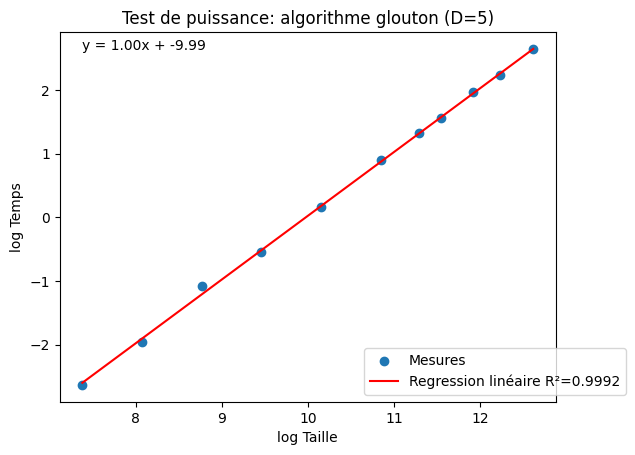

In [9]:
import math

def values_test_puissance(measures):
    return { math.log(x) : math.log(y) for x, y in measures.items() }

display_test_puissance(values_test_puissance(mesures_glouton), "Test de puissance: algorithme glouton (D=5)")

On remarque que les points suivent de près la forme d'une droite valeur, ce qui semble indiquer que la croissance du temps de calcul de l'algorithme glouton est polynomiale. De plus, puisque la pente et l'ordonnée à l'origine sont respectivement 1,00 et -9,99 ; on peut déduire que le temps de calcul de l'algorithme semble suivre l'équation $y = e^{-9.99} \times x$. On peut aussi remarquer que la pente est de 1, ce qui semble indiquer que la complexité de l'algorithme pour un nombre constant de doigts devrait se situer autour de $\Theta (k)$, où k est la longueur de la mélodie.

#### Test du rapport

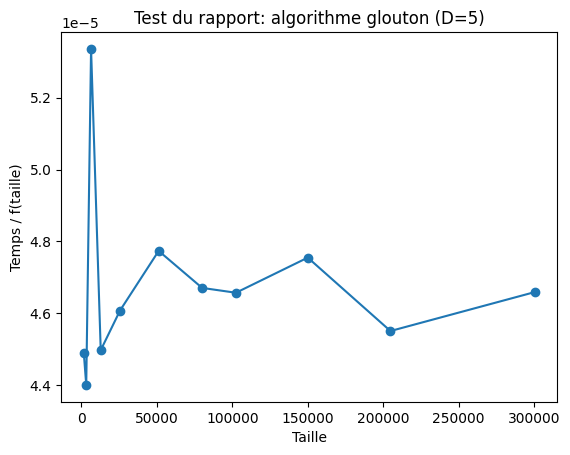

In [10]:
def values_test_rapport(measures, f):
    return { x : y / f(x) for x, y in measures.items() }

def f(x):
    return x

display_test_rapport(values_test_rapport(mesures_glouton, f), "Test du rapport: algorithme glouton (D=5)")

Puisque l'algorithme glouton semble croître linéairement en fonction de la longueur de la mélodie pour un nombre de doigts fixé, la fonction $f(x) = x$ permettrait donc de confirmer que la croissance de l'algorithme en fonction de la longueur de la mélodie pour un nombre de doigts fixé est réellement linéaire. On remarque que le rapport entre le temps de calcul et la fonction f semble converger vers une valeurs autour de 4,6e-5, ce qui semble confirmer que la croissance de l'algorithme glouton pour un nombre de doigts constant est bel et bien linéaire ($\Theta(k)$).

#### Test des constantes

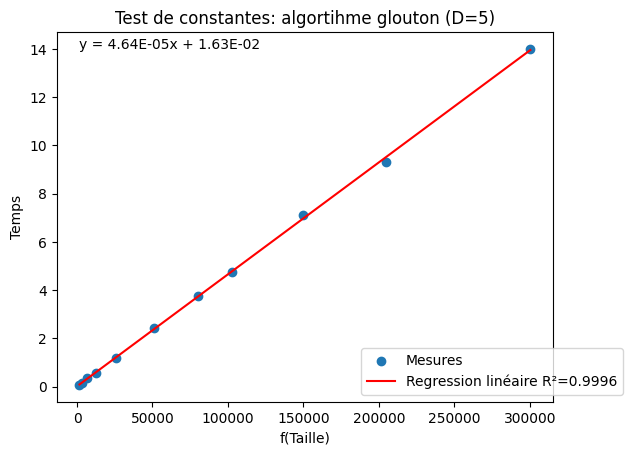

In [11]:
def values_test_constantes(measures, f):
    return { f(x) : y for x, y in measures.items() }

def f(x):
    return x

display_test_constantes(values_test_constantes(mesures_glouton, f), "Test de constantes: algortihme glouton (D=5)")

Pour une fonction $f(x) = x$, on remarque que les points suivent de très près la forme d'une droite. Ce qui indique que le temps de calcul en fonction de la taille de la mélodie k semble suivre l'équation: $t(k) = c \times f(k) = 0.0000464k - 0.0163$.

## Partie 2 : Algorithme de programmation dynamique

L'algorithme de programmation dynamique remplit un tableau des coûts de transition optimaux en
fonction de la mélodie.

Notons `J(k, d)` la somme minimale des coût de transition associée à la mélodie `(ak, ... , an−1)` (c’est-à-
dire au suffixe de longueur `n - k` de la mélodie de départ) où l’on joue la première note ak avec le doigt
d.

Alors, J vérifie la relation de récurrence (1) :

J(k, d) = min { 0≤ d’ ≤ D-1} [ C(ak, d, ak+1, d’ ) + J(k + 1, d’ ) ]

et la condition terminale (2) :

J(n - 1, d) = 0, ∀d = 0, ... , D - 1

Comme on ne connaît pas le premier doigt à utiliser a priori, la solution au problème original est
donnée par (3) :

min { 0 ≤ d ≤ D-1} J(0, d)

Cette récurrence est résolue par programmation dynamique pour déterminer la solution au problème.
Note : Pour vous aider à vérifier que votre implantation fonctionne correctement, voici deux solutions
que vous devriez obtenir avec cet algorithme (dépendant de votre implantation, il pourrait être possible
que vous arriviez au même coût, mais avec une différente suite de doigts) :

- twinkle_twinkle.txt ; coût = 31; doigts = [0, 0, 4, 3, 4, 4, 3, 2, 2, 1, 1, 0, 1, 0, 4, 4, 3, 3, 2, 2, 0, 4, 4, 3,
3, 2, 2, 1, 0, 0, 4, 3, 4, 4, 3, 2, 2, 1, 1, 0, 1, 0]

- fur_elise.txt ; coût = 1091; doigts = [1, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4,
4, 0, 1, 4, 4, 0, 4, 3, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0,4, 3, 0, 1, 2, 3, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 3, 3, 3, 4, 0, 1, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 0, 1, 3, 4, 0, 4, 0,
1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 4, 3, 0, 1, 2, 3, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 3, 3, 3, 4, 0, 1, 0, 1, 0, 1, 0, 4,
4, 4, 0, 1, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 4, 3, 2, 0, 1, 2, 0, 1, 0, 2, 1, 1, 0, 4, 4, 4, 3,
2, 1, 0, 1, 0, 0, 2, 1, 0, 0, 1, 2, 3, 3, 4, 3, 4, 0, 1, 2, 0, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 1, 0, 4, 4, 4, 4, 3, 2, 1,
0, 4, 3, 1, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 1, 0, 4, 4, 4, 4, 3, 2, 1, 0, 2, 1, 0, 1, 2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4,
4, 0, 4, 3, 0, 1, 2, 3, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 4]

Implantez l'algorithme de programmation dynamique.

Coût Programmation Dynamique : 31


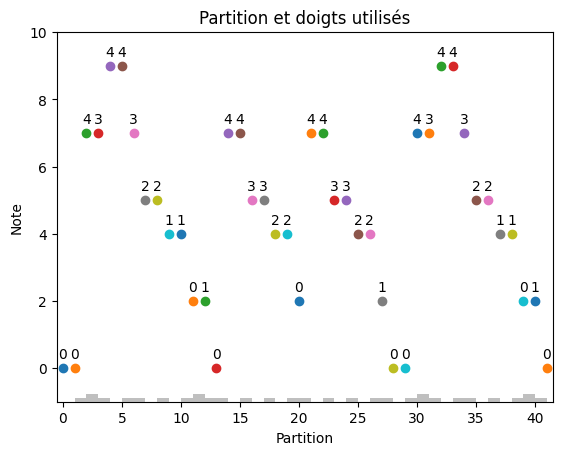

In [12]:
def j(d, next_row, transition):
    next_finger, total_cost = -1, math.inf
    
    for finger in range(D):
        current_total_cost = getCosts(costs, transition, [d, finger])[0] + next_row[finger][-1]

        if total_cost > current_total_cost:
            next_finger, total_cost = finger, current_total_cost 
    
    return d, next_finger, total_cost


def progDyn(partition):
    n = len(partition)

    # Tableau des coûts et transitions
    solution_costs = np.zeros((n, D), dtype=[('previous_finger', 'int32'), ('next_finger', 'int32'), ('total_cost', 'int32')])
    
    for k in range((n-1)-1, -1, -1):
        row = solution_costs[k]
        next_row = solution_costs[k+1]
        
        for col, finger in enumerate(range(D)):
            solution_costs[k, col] = j(finger, next_row, [partition[k], partition[k+1]])

    first_stroke, next_stroke, _ = min(solution_costs[0], key=lambda value : value[2])

    solution = []
    solution.append(first_stroke)

    for i in range(1, n-1):
        current_stroke, next_stroke, _ = solution_costs[i][next_stroke]
        solution.append(current_stroke)

    solution.append(next_stroke)
    
    return solution


solutionDyn = progDyn(partition)
print("Coût Programmation Dynamique :", getTotalCost(costs, partition, solutionDyn))
visualize_solution(costs, partition, solutionDyn)

On remarque que, pour les transitions (i, j), i est en général plus petit ou égal à j. Ce qui semble indiquer qu'il est en général plus avantageux de choisir une transition (i, j) quand i >= j, ce qui confirme le constat observé pour l'algorithme glouton.

### Analyse asymptotique

Dans cette analyse, vous tiendrez compte à la fois de la longueur de la mélodie mais également du
nombre de doigts pour chacun des trois algorithmes.

L'analyse de l'algorithme est fait pour un nombre $d$ de doigts et un nombre $k$ pour la longueur de la mélodie. L'exécution de l'algorithme est composé de trois étapes : la création du tableau, le remplissage du tableau et la recherche de la solution optimale.

D'abord, l'algorithme crée un tableau de taille $k \times d$, ce qui est en $\Theta (kd)$ pour enregister les coûts et les transitions. 

Puis, dans une double boucle imbriquée qui itères sur les $(k-1) \times d$ élements du tableau, il remplis le tableau en calculant pour chaque élément le coût $J(k, d)$ avec la fonction $j$. La fonction $j$ effectue une boucle sur tous les doigts pour trouver la transition optimale et, à chaque itération, il fait appel à la fonction $getCosts$. Puisqu'on donne toujours la même taille d'exemplaire à la fonction $getCosts$ à chaque itération, on peut déduire que la complexité de la fonction $j$ est en $d \times \Theta(1) = \Theta(d)$. Donc, la complexité du remplissage du tableau est en $(k-1) \times d \times \Theta(d) = \Theta(kd^2)$

Ensuite, pour obtenir la solution, on trouve l'élément dans la première ligne du tableau avec le plus petit coût total (en $\Theta(d)$) et on ajoute chaque transition jusqu'à la fin de la mélodie dans une boucle ; la complexité de la boucle est donc en $\Theta(d) + \Theta(k) = \Theta(d + k)$

Pour conclure, la complexité en temps de calcul de l'algorithme est en $\Theta(kd) + \Theta(kd^2) + \Theta(d + k) = \Theta(kd^2)$. Lorsque la taille de la mélodie est constante et le nombre de doigts varie, la complexité est en $\Theta(d^2)$ et, lorsque le nombre de doigts est constant et la taille de la mélodie varie, la complexité est en $\Theta(k)$.

On peut aussi déduire que la complexité en mémoire de l'algorithme programmation dynamique est en $\Theta(k) + \Theta(kd) = \Theta(kd)$, car on doit créer la solution qui est de taille $k$ et le tableau des coûts et transitions qui est de taille $k \times d$.

### Mesures

Rapportez dans un tableau les temps d'exécutions moyens avec les fonctions auxiliaires `measure_procedure` et `display_measure_table`

In [13]:
dataset = get_dataset(2136374, [1600, 3200, 6400, 12800, 25600, 51200, 80000, 102400])

In [14]:
mesures_dyn = measure_procedure(progDyn, dataset)

In [15]:
display_measures_table(mesures_dyn)

Taille       Temps moyen (s)
1600         0.33266773223876955
3200         0.7392292976379394
6400         1.3823112964630127
12800        2.83475022315979
25600        5.6573834896087645
51200        11.38992624282837
80000        17.689455842971803
102400       22.438186168670654


### Validation empirique

Servez-vous de vos temps d'exécution pour confirmer et/ou préciser l'analyse asymptotique théorique de vos algorithmes avec la méthode hybride de votre choix.

La méthode peut varier d'un algorithme à l'autre. Justifiez les choix ici et avec des graphiques.

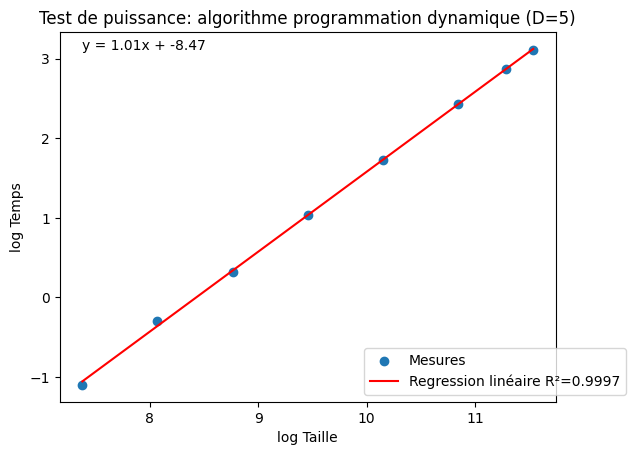

In [16]:
display_test_puissance(values_test_puissance(mesures_dyn), "Test de puissance: algorithme programmation dynamique (D=5)")

On remarque que les points suivent de près la forme d'une droite de pente proche de 1, cela semble indiquer que la complexité de l'algorithme dynamique pour un nombre de doigts fixé est autour du linéaire ($\Theta(k)$).

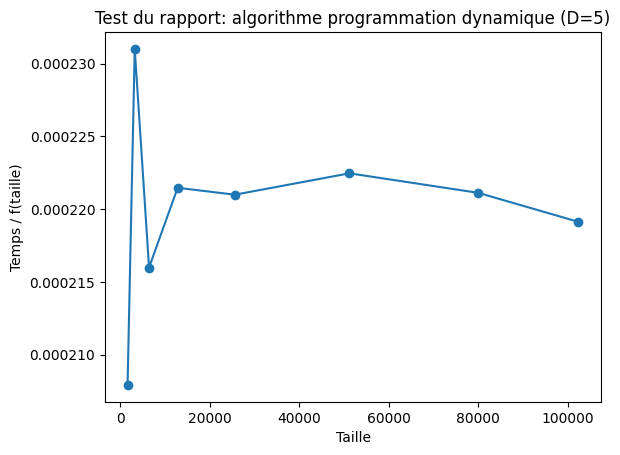

In [17]:
def f(x):
    return x

display_test_rapport(values_test_rapport(mesures_dyn, f), "Test du rapport: algorithme programmation dynamique (D=5)")

On remarque que le rapport entre le temps de calcul et la fonction f(x) = x converge vers une valeur proche de 0,0002175. Ce qui semble confirmer que la croissance de l'algorithme programmation dynamique pour un nombre de doigts fixé est linéaire ($\Theta(k)$).

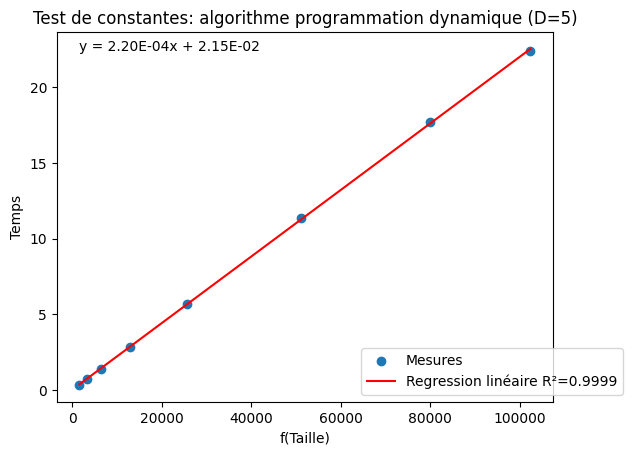

In [18]:
def f(x):
    return x

display_test_constantes(values_test_constantes(mesures_dyn, f), "Test de constantes: algorithme programmation dynamique (D=5)")

Pour une fonction $f(x) = x$, on remarque que les points suivent de très près la forme d'une droite. Ce qui indique que le temps de calcul en fonction de la taille de la mélodie k semble suivre l'équation: $t(k) = c \times f(k) = 0.00022k + 0.0215$. 

On peut remarquer que la pente de la droite est environ 5 fois plus grande que celle obtenue pour l'algorithme glouton ($0.00022 / 0.0000464 = 4.741 \approx 5$). En comparant les deux algorithmes, il est possible de tirer deux constats qui permet d'expliquer la différence en temps de calcul.

Sachant la complexité en temps de calcul de l'algorithme glouton est en $O(d^2 + kd)$, pour une valeur $k$ >> $d$, on peut dire que la complexité de l'algorithme glouton est à peu près de $O(kd)$. Donc, dans le pire cas, le rapport entre le temps de calcul de l'algorithme programmation dynamique et l'algorithme glouton est de l'ordre de $O(kd^2) / O(kd) = O(d)$. Par conséquent, pour un nombre de doigts constant, le rapport entre le temps de calcul des deux algorithmes s'approche d'une constante $c \times d$, où $c \in \mathbb {R^*}_{+}$.

Ensuite, puisque les appels de la fonction $j$ et get_next_finger effectue un traitement similaire, soit le choix de la meilleur transition pour un certain doigt initial dans une boucle de $d$ itération appelant $getCost$, on peut déduire que le temps de calcul additionnel pour l'algorithme programmation dynamique est principalement à cause d'un plus grand nombre d'itération de la fonction $j$. 

Donc, on peut conclure que le rapport entre les deux algorithmes s'approche d'une constante $c \times d \approx 1 \times d = d$, ce qui explique pourquoi le rapport des temps de calcul entre les deux algorithmes est environ de 5.

## Partie 3 : Algorithme de recherche locale

Cet algorithme explore le voisinage de solutions non optimales. En partant d’une solution gloutonne, la
solution est améliorée en tentant d’échanger un doigt pour un autre sur une note. Vous pourrez prendre
comme critère d’arrêt un nombre maximal d’itérations.

Coût Recherche aléatoire: 31


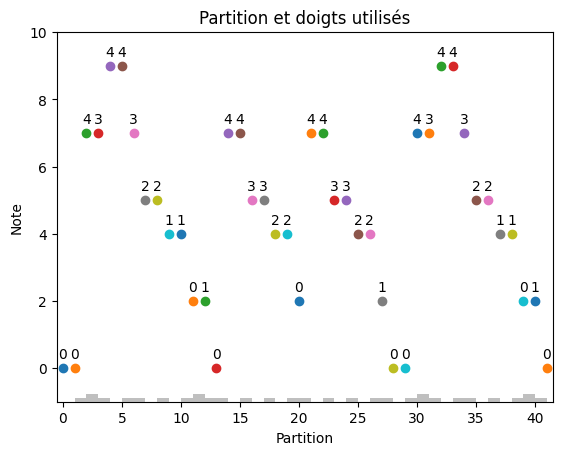

In [32]:
import random


nombre_max_iteration = 1000


def localSearch(partition):
    solution = glouton(partition)
    better_cost = getTotalCost(costs, partition, solution)

    for _ in range(nombre_max_iteration):
        index = random.randint(0, len(solution)-1)
        next_finger = random.randint(0, D-1)
        previous_finger = solution[index]
        
        if next_finger == solution[index]:
            next_finger = (next_finger + 1) % D

        solution[index] = next_finger
        current_cost = getTotalCost(costs, partition, solution)

        if current_cost > better_cost:
            solution[index] = previous_finger
        else:
            better_cost = current_cost

    return solution


solutionLocal = localSearch(partition)
print("Coût Recherche aléatoire:", getTotalCost(costs, partition, solutionLocal))
visualize_solution(costs, partition, solutionLocal)

On obtient la même coût que celui trouvé avec l'algorithme programmation dynamique. On déduit qu'avec un nombre suffisamment grand d'itérations il est possible d'obtenir une solution optimale. Cependant, plus on effectue d'itération, plus il faudra de temps de calcul.

### Analyse asymptotique

Dans cette analyse, vous tiendrez compte à la fois de la longueur de la mélodie mais également du
nombre de doigts pour chacun des trois algorithmes.

L'analyse de l'algorithme est fait pour un nombre $d$ de doigts, un nombre $k$ pour la longueur de la mélodie et un nombre $n$ d'itération. L'exécution de l'algorithme est composé de deux étapes.

On obtient une premiere solution grace a notre algorithme glouton dont la complexité est $\Omega(k)$ et en $O(d^2 + kd)$.

Puis, on change la solution dans une boucle pour $n$ itération, où à chaque itération on change solution d'un doigt choisi aléatoirement et calcul le nouveau coût de la solution. À chaque itération, on fait appel à la fonction getTotalCost, ce qui permet de déduire que chaque itération se fait en $\Theta(k)$ parce que c'est la seule opération dont la complexité n'est pas en temps constant. Donc, la complexité de la boucle est en $n \times \Theta(k) = \Theta(nk)$

La complexité en temps de calcul de l'algorithme est donc en $\Omega(1) + \Omega(nk) = \Omega(nk)$ et en $O(d^2 + kd) + O(nk) = O(d^2 + (n+d)k)$. Lorsque la taille de la mélodie est constante et le nombre de doigts varie, la complexité est en $\Omega(1)$ et en $O(d^2)$, et, lorsque le nombre de doigts est constant et la taille de la mélodie varie, la complexité est en $\Theta(nk)$. 

Comme pour l'algorithme glouton, la complexité en mémoire de l'algorithme recherche locale est aussi de $\Theta(k)$, car on crée une liste de doigts de taille $k$ pour la solution.

### Mesures

Rapportez dans un tableau les temps d'exécutions moyens avec les fonctions auxiliaires `measure_procedure` et `display_measure_table`

In [33]:
dataset = get_dataset(2136374, [1600, 3200, 6400, 12800, 25600, 51200, 80000, 102400])
mesures_local = measure_procedure(localSearch, dataset)
display_measures_table(mesures_local)

Taille       Temps moyen (s)ple 5 of size 102400...          
1600         0.3874868392944336
3200         0.8640449523925782
6400         1.6601632595062257
12800        3.2579134464263917
25600        6.51185884475708
51200        13.121672010421753
80000        20.950666093826293
102400       26.658760833740235


### Validation empirique

Servez-vous de vos temps d'exécution pour confirmer et/ou préciser l'analyse asymptotique théorique de vos algorithmes avec la méthode hybride de votre choix.

La méthode peut varier d'un algorithme à l'autre. Justifiez les choix ici et avec des graphiques.

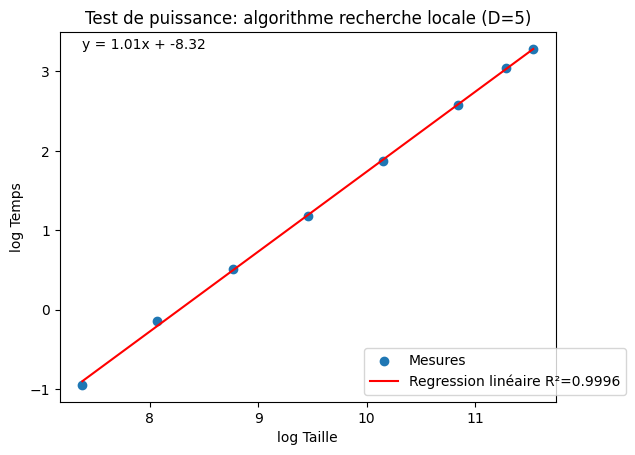

In [34]:
display_test_puissance(values_test_puissance(mesures_local), "Test de puissance: algorithme recherche locale (D=5)")

On remarque que les points suivent de près la forme d'une droite valeur, ce qui semble indiquer que la croissance du temps de calcul de l'algorithme recherche locale est polynomiale. Puisque la pente de la droite semble être autour de 1, on peut aussi déduire que le temps de calcul de l'algorithme recherche locale est de l'ordre du linéaire pour un nombre de doigts constant.

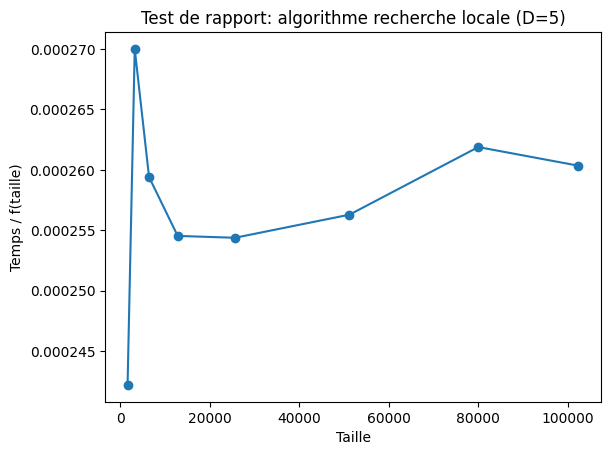

In [35]:
def f(x):
    return x

display_test_rapport(values_test_rapport(mesures_local, f), "Test de rapport: algorithme recherche locale (D=5)")

On remarque que le rapport entre le temps de calcul et la fonction f(x) = x semble converger vers une valeur proche de 0,00026, ce qui semble indiquer que la croissance de l'algorithme recherche locale est linéaire pour un nombre de doigts constant.

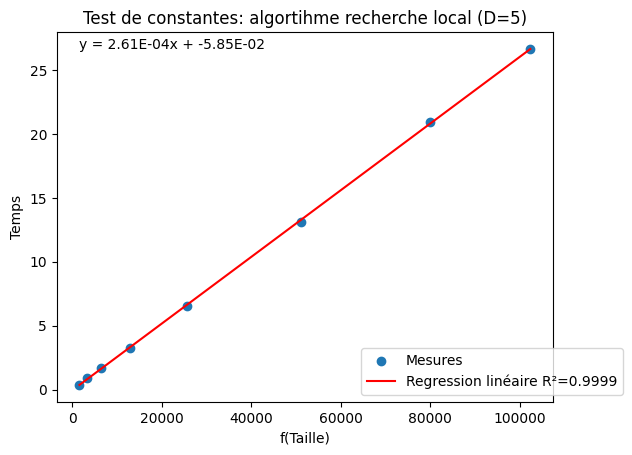

In [36]:
def f(x):
    return x

display_test_constantes(values_test_constantes(mesures_local, f), "Test de constantes: algortihme recherche local (D=5)")

Pour une fonction $f(x) = x$, on remarque que les points suivent de très près la forme d'une droite. Ce qui indique que le temps de calcul en fonction de la taille de la mélodie k semble suivre l'équation: $t(k) = c \times f(k) = 0.000261k - 0.0585$.

On remarque que le temps de calcul de l'algorithme recherche locale est plus grand que le temps de calcul de l'algorithme programmation dynamique. Ceci est dû au fait qu'on effectue trop d'itérations pour la recherche locale.

# Conclusion et synthèse

De facon assez général on peux dire que les 3 algorithmes ont une complexité plus ou moins linéaire pour un nombre de doigts constant. Cependant, on peut remarquer que pour avoir une meilleure solution, il faut utiliser plus de temps de calcul. L'algorithme glouton permet d'obtenir une solution rapidement, mais ne garantie pas qu'elle sera optimale. L'algorithme programmation dynamique permet d'obtenir une solution optimale, mais elle représente l'algorithme le plus coûteux en terme de ressources (temps de calcul et mémoire). L'algorithme recherche locale est un compromis entre temps de calcul et la qualité de la solution ; plus on augmente le nombre d'itération, et par conséquent le temps de calcul, plus on se rapprochera d'une solution optimale ou au moins un optimum local.